In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [41]:
!unzip /content/gdrive/MyDrive/257GP-DriverDistraction/imgs.zip -d mydata 

Archive:  /content/gdrive/MyDrive/257GP-DriverDistraction/imgs.zip
replace mydata/test/img_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mydata/test/img_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.utils import to_categorical

In [13]:
#Read the data from csv
driver_imgs_list = pd.read_csv("/content/gdrive/MyDrive/257GP-DriverDistraction/driver_imgs_list.csv")
test_imgs_list = pd.read_csv("/content/gdrive/MyDrive/257GP-DriverDistraction/Labeled_Test_Data.csv")

# Splitting of Images into Training Data and Validation Data

In [14]:
#List of Drivers to be sepearted for validation
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [15]:
#Split Data based on the selected drivers
random_list = np.random.permutation(len(driver_imgs_list))
df_copy = driver_imgs_list.iloc[random_list]
training_image_paths = []
training_image_labels =[]
validation_image_paths = []
validation_image_labels =[]
for (index, row) in df_copy.iterrows():
    if(row.subject) in driv_selected:
        validation_image_paths.append("/content/mydata/train/"+row.classname+'/'+row.img)
        validation_image_labels.append(int(row.classname[1]))
    else:
        training_image_paths.append("/content/mydata/train/"+row.classname+'/'+row.img)
        training_image_labels.append(int(row.classname[1]))

# Creating Test Images Path and Labels

In [26]:
random_test_list = np.random.permutation(len(test_imgs_list))
df_test_copy = test_imgs_list.iloc[random_test_list]
testing_image_paths = []
testing_image_labels =[]
for (index, row) in df_test_copy.iterrows():
        testing_image_paths.append("/content/gdrive/MyDrive/257GP-DriverDistraction/Test_Data/"+row.classname+'/'+row.img)
        testing_image_labels.append(int(row.classname[1]))

# Feature Extraction using HOG

In [17]:
#Obtain the images from the paths and resize and preprocess them to convert in to HOG feature.
def ConvertImages(paths, labels):
    images_paths = np.array(paths)
    data = []
    for i in range(len(images_paths)):
        image = mpimg.imread(images_paths[i])
        image = image[50:,120:-50]
        image = cv2.resize(image,(64,64)) 
        data.append([image,labels[i]])
    plt.imshow(data[0][0])
    data = np.transpose(data)
    hog_features = []
    hog_features = ExtractHogFeature(np.array(data[:][0]))
    return CreateDataFrame(hog_features, np.array(data[:][1]))

In [18]:
#Extract the HOG Feature from the image data
def ExtractHogFeature(data):
    data_gray = [ color.rgb2gray(i) for i in data]
    plt.imshow(data_gray[0])
    ppc = 16
    hog_images = []
    hog_features = []
    for image in data_gray:
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
    hog_features = np.array(hog_features)
    return hog_features
    

In [19]:
#Convert the extracted features and labels into dataframe
def CreateDataFrame(hog_features, labels):
    data_frame = []
    for i in range(len(hog_features)):
        data_frame.append(np.hstack((hog_features[i],labels[i]))) 
    np.random.shuffle(data_frame)
    data_frame = np.array(data_frame)
    x = data_frame[:len(data_frame),:-1]
    y = data_frame[:len(data_frame),-1:].ravel()
    return x,y

Shape of training data  (18732, 128)
Shape of training labels  (18732,)


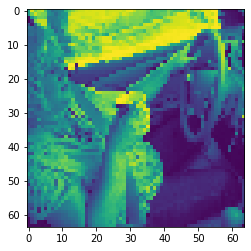

In [20]:
#Get the training data 
x_train, y_train = ConvertImages(training_image_paths, training_image_labels)
print("Shape of training data ", x_train.shape)
print("Shape of training labels ", y_train.shape)

Shape of validation data  (3692, 128)
Shape of validation labels  (3692,)


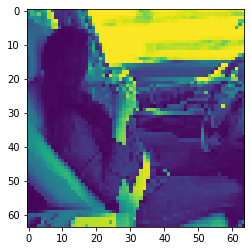

In [21]:
#Get the validation data
x_valid, y_valid = ConvertImages(validation_image_paths, validation_image_labels)
print("Shape of validation data ",x_valid.shape)
print("Shape of validation labels ",y_valid.shape)

# SVM

In [22]:
# Get the best tunning parameters for SVM
tuned_parameters = [{'kernel': ['rbf'], 'C': [0.1, 1, 10]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
                    {'kernel': ['poly'], 'C': [0.1, 1, 10]}]

clf8 = GridSearchCV(
        SVC(), tuned_parameters, cv = 5
    )
clf8.fit(x_train, y_train)
print("Best parameters to train are: ", clf8.best_params_)

Best parameters to train are:  {'C': 10, 'kernel': 'rbf'}


In [23]:
#Create an SVM Model for classification
model_svm = svm.SVC(C=10)
print(model_svm)
model_svm.fit(x_train,y_train)
y_pred_val = model_svm.predict(x_valid)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [24]:
print("Accuracy Score for SVM ", accuracy_score(y_valid, y_pred_val))
print(classification_report(y_valid, y_pred_val))
print(confusion_matrix(y_valid, y_pred_val))

Accuracy Score for SVM  0.48320693391115926
              precision    recall  f1-score   support

         0.0       0.36      0.50      0.42       412
         1.0       0.75      0.55      0.64       339
         2.0       0.36      0.36      0.36       348
         3.0       0.67      0.32      0.43       399
         4.0       0.32      0.57      0.41       396
         5.0       0.80      0.66      0.72       403
         6.0       0.63      0.49      0.55       392
         7.0       0.61      0.74      0.67       334
         8.0       0.54      0.52      0.53       332
         9.0       0.14      0.12      0.13       337

    accuracy                           0.48      3692
   macro avg       0.52      0.48      0.49      3692
weighted avg       0.52      0.48      0.49      3692

[[204   2   6  22 133   1   0   0   5  39]
 [ 34 187  14  26   8   0   3   1  28  38]
 [ 44   0 125   6   0   0  67  75  20  11]
 [ 14  56   3 126 188   2   0   1   5   4]
 [ 57   0   6   4 224   1

# SVM - Test Data

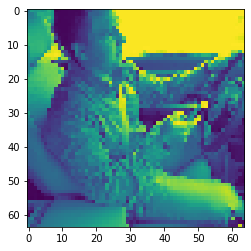

In [27]:
x_test, y_test = ConvertImages(testing_image_paths, testing_image_labels)

In [30]:
y_test_val = model_svm.predict(x_test)

In [32]:
print("Accuracy Score for SVM Test Images ", accuracy_score(y_test, y_test_val))
print(classification_report(y_test, y_test_val))
print(confusion_matrix(y_test, y_test_val))

Accuracy Score for SVM Test Images  0.48135593220338985
              precision    recall  f1-score   support

         0.0       0.48      0.34      0.40        38
         1.0       0.66      0.53      0.58        36
         2.0       0.68      0.51      0.58        37
         3.0       0.50      0.44      0.47        27
         4.0       0.52      0.43      0.47        35
         5.0       0.71      0.69      0.70        32
         6.0       0.53      0.58      0.55        31
         7.0       0.59      0.57      0.58        35
         8.0       0.04      0.17      0.06         6
         9.0       0.09      0.17      0.12        18

    accuracy                           0.48       295
   macro avg       0.48      0.44      0.45       295
weighted avg       0.54      0.48      0.51       295

[[13  1  1  5  3  3  2  0  1  9]
 [ 2 19  0  1  0  2  3  1  3  5]
 [ 0  1 19  0  2  0  3  4  7  1]
 [ 4  2  1 12  4  1  0  0  1  2]
 [ 3  0  2  2 15  1  1  3  2  6]
 [ 2  1  0  2  0 22 

# KNN

In [33]:
#Plot the cross validation score for neighbours in range 1 to 5
k_range = list(range(1,5))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='auto', weights='uniform')
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    k_scores.append(scores.mean())

Text(0.5, 1.0, 'KNN Model for Accuracy')

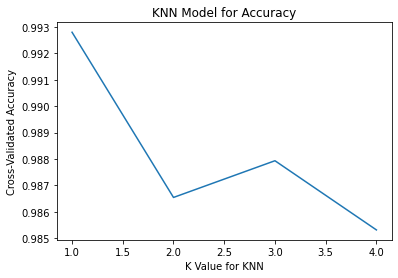

In [34]:
plt.plot(k_range, k_scores)
plt.xlabel('K Value for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Model for Accuracy')

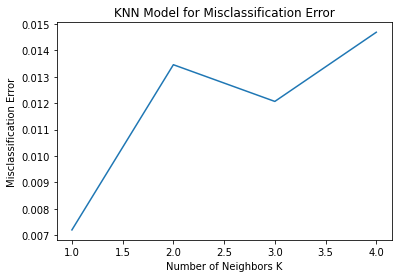

In [35]:
MSE = [1 - x for x in k_scores]

optimal_k = k_range[MSE.index(min(MSE))]

plt.plot(k_range, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('KNN Model for Misclassification Error')
plt.show()

In [36]:
print("The best k for KNN classifcation to be used on this model is 3")

The best k for KNN classifcation to be used on this model is 3


In [37]:
#Train the knn model 
model_knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, algorithm='auto', weights='uniform')
print(model_knn)
model_knn = model_knn.fit(x_train, y_train)
y_predicted_knn = model_knn.predict(x_valid)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')


In [38]:
print("Accuracy Of KNN ", accuracy_score(y_valid, y_predicted_knn))
print(classification_report(y_valid, y_predicted_knn))
print(confusion_matrix(y_valid, y_predicted_knn))

Accuracy Of KNN  0.46289274106175515
              precision    recall  f1-score   support

         0.0       0.36      0.38      0.37       412
         1.0       0.50      0.63      0.56       339
         2.0       0.33      0.60      0.43       348
         3.0       0.59      0.61      0.60       399
         4.0       0.37      0.32      0.34       396
         5.0       0.74      0.77      0.76       403
         6.0       0.49      0.37      0.42       392
         7.0       0.69      0.48      0.57       334
         8.0       0.36      0.21      0.26       332
         9.0       0.25      0.23      0.24       337

    accuracy                           0.46      3692
   macro avg       0.47      0.46      0.45      3692
weighted avg       0.47      0.46      0.46      3692

[[157  31  20  48  47  22   4   0   8  75]
 [ 21 213  39  13  16   2  22   0   6   7]
 [  8  17 208  12  23   1  32  15  25   7]
 [ 11  35  13 243  76   0  16   0   2   3]
 [129   9  28  53 126   6   9   

# KNN - Test

In [39]:
y_test_knn = model_knn.predict(x_test)

In [40]:
print("Accuracy Score for KNN Test Images ", accuracy_score(y_test, y_test_knn))
print(classification_report(y_test, y_test_knn))
print(confusion_matrix(y_test, y_test_knn))

Accuracy Score for KNN Test Images  0.4440677966101695
              precision    recall  f1-score   support

         0.0       0.56      0.39      0.46        38
         1.0       0.49      0.61      0.54        36
         2.0       0.47      0.38      0.42        37
         3.0       0.42      0.56      0.48        27
         4.0       0.46      0.51      0.49        35
         5.0       0.79      0.69      0.73        32
         6.0       0.34      0.32      0.33        31
         7.0       0.44      0.40      0.42        35
         8.0       0.09      0.17      0.12         6
         9.0       0.00      0.00      0.00        18

    accuracy                           0.44       295
   macro avg       0.40      0.40      0.40       295
weighted avg       0.46      0.44      0.45       295

[[15  2  1  7  3  2  2  0  0  6]
 [ 1 22  3  2  1  1  1  3  0  2]
 [ 0  4 14  0  2  0  6  4  3  4]
 [ 2  1  1 15  5  1  0  0  1  1]
 [ 1  2  2  5 18  0  4  2  0  1]
 [ 2  0  0  2  2 22  